# Aprendizado de máquina: exemplo de processo, do começo ao fim

Para exemplificar o modelo básico que segue um projeto de aplicação de aprendizado de máquina, utilizaremos um conjunto de dados dos custos de moradias em distritos do estado da Califórnia. O objetivo é criar um algoritmo capaz de predizer o custo médio de moradias em um distrito com base em suas características. Este problema é _supervisado_, dado que cada distrito já contém uma "etiqueta" com a resposta correta (o custo médio de moradia). É também um problema de _regressão multivaria_, uma vez que queremos utilizar um conjunto de parâmetros para determinar um outro. Estamos trabalhando com um conjunto de dados fixo (isto é, ele não será atualizado continuamente) e relativamente pequeno, então é suficiente desenvolver um método de _batch learning_, isto é, um método que aprende a resolver o problema a partir de um único conjunto de dados iniciais (em oposição a ser capaz de aprender com conjuntos incrementais ao longo do tempo).

## Adquirindo os dados

Primeiro, temos que baixar o conjunto de dados a serem analizados. Seria possível apenas armazenar esses dados localmente, e simplesmente pedir ao Python que acesse os arquivos. É conveniente, entretanto, escrever um bloco de código que baixe e prepare o conjunto de dados diretamente da fonte, que pode então atualizar esses dados sempre que necessário a partir de um repositório online, que pode ser acessado por todos os membros de um projeto.  

In [1]:
import os 
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [2]:
fetch_housing_data()

In [3]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

#### Conhecendo os dados

Podemos começar simplesmente olhando alguns dados para identificarmos alguns parâmetros e valores. 

In [4]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Algumas outras verificações podem ser feitas chamando o método _info()_: o número de entrada de dados, os parâmetros, e o número de valores de não-nulos para cada parâmetro, além do tipo de cada um desses atributos.

In [5]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Esta verificação já nos permite notar um problema: há 207 entradas sem o parâmetro "total_bedrooms". Este é um problema com o qual teremos que lidar quando começarmos a fazer a análise dos parâmetros e suas relações. Duas alternativas de exemplo são simplesmente descartar essas entradas, ou preencher os campos vazios com a mediana do parâmetro no restante das entradas.

Notamos que o atributo "ocean_proximity" é o único do tipo "objeto". Em princípio, esse poderia ser qualquer tipo de objeto do Python, mas dado que os dados estão vindo de um arquivo .csv, sabemos que deve ser uma linha de texto. Antes mesmo de analizar esse atributo diretamente, a tabela que recebemos do método _header()_ nos mostra uma repetição de um mesmo valor em várias entradas; este atributo é provavelmente uma categoria; isto é, há alguns preenchimentos fixos possíveis para ele. Podemos ver os valores possíveis de um atributo chamando o método _value_counts()_.

In [6]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Quanto aos atributos numéricos, começamos a estudá-los com _describe()_.

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


O valor "count" em _total_bedrooms_ nos mostra que os campos nulos são ignorados na contagem. _std_ é o desvio padrão do atributo, e as porcentanges, chamdas percentis, indicam o valor abaixo do qual $x\%$ dos valores se encontram.

Para termos uma visão mais geral da distribuição dos valores de cada atributo, plotamos um histograma de cada um deles.

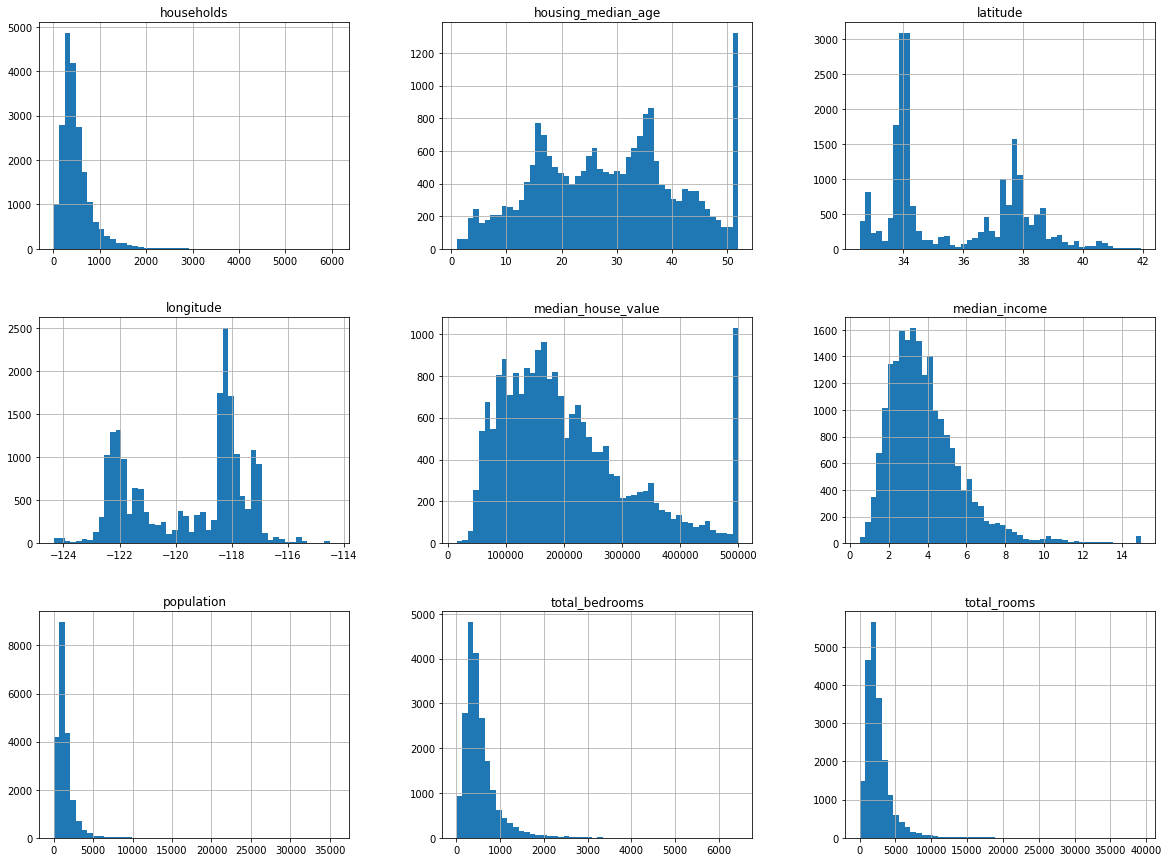

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

Neste ponto podemos começar a nota algumas características dos dados e sobre como foram preparados. 
* Claramente, o atributo _median_income_ não está determinado no valor real  em doláres da renda de uma família. Neste problema, os dados foram escalados e limitados a 15,0001 para rendas mais altas e 0,4999 para rendas mais baixas.
* Podemos notar que uma limitação superior parece ter sido imposta também sobre os parâmetros _median_house_value_ e _house_median_age_ pelo pico súbito no maior valor representado em ambos os casos. Essa limitação sobre o valor médio das casas pode se tornar um problema, dado que é o valor que queremos aprender a prever. Ela não será um problema se precisão para valores acima de 500.000 não for necessária, mas caso seja, temos a princípio duas opções
    * Coletar valores adequados para as entradas que foram limitadas.
    * Descartar os distritos afetados do conjunto.
* As escalas dos atributos são muito diferentes.
* Muitos histogramas são o que é chamado de _tail_heavy_: se extendem muito mais para a direita da mediana do que para a esquerda.

Este tipo de análise é importante para que tenhamos uma ideia do tipo de dados com que estamos lidando, qual foi o pré-processamento pelo qual passaram e para encontrarmos possíveis problemas antes que comecemos a construir um método que não os leve em conta e, no final, falhe.

#### Criando conjuntos de treino e teste

Pré-análise demais, entretanto, pode ser prejudicial. Ao procuramos com muito afinco por padrões e características que possam nos ajudar a encontrar o melhor modelo de aprendizado possível, podemos acabar nos prendendo a características muito específicas deste conjunto de dados em particular, e causar um _overfitting_, de modo que o modelo, embora tenha ótima performance para estes dados, falhará em dar resultados para outros. Este efeito é chamado _snooping bias_.

Devemos então já criar um conjunto de teste, que ficará separado do conjunto de treinamento. A priori, podemos simplesmente tomar um conjunto aleatórios de dados, totalizando 20% do conjunto inteiro, e separá-los como nosso conjunto de teste. Isso, entretanto, criará um conjunto de dados diferente toda vez que executarmos o programa, e ao longo do tempo nós e o algoritmo teremos analizado e estudado o conjunto inteiro, retornando à situação que queremos evitar.

Se estivéssemos lidando com um único conjunto de dados _sempre_, poderíamos apenas definar uma semente para o gerador aletório e receber sempre o mesmo conjunto. Se viermos a atualizar os dados no futuro, entretanto, o novo conjunto pode misturar dados que já estavam no conjunto de testes com dados que estavam no conjunto de treinamento.

Digamos que queremos manter a possibilidade de atualização do conjunto dos dados em aberto. Precisamos então de um modo de identificar cada entrada individualmente. Uma solução comum é utilizar o identificador de cada instância para decidir se ela vai ou não para o conjunto de testes (se as instâncias possuírem identifiadores).

Os métodos propostos até aqui se basearam em uma seleção aleatória. Entretanto, exceto em casos de conjuntos muito grandes, isso introduz o risco de gerar um conjunto de treinamento com algum viés, isto é, que não represente bem a população total dos nossos dados. Se soubermos, por exemplo, que a renda mediana é muito importante para nossa predição, podemos querer ter certeza que nossos conjuntos representem bem as proporções desse atributo no conjunto total.

Se dividirmos o atributo em classes, devemos tomar cuidado para que não tenhamos classes demais, de modo que cada uma delas tenha instâncias suficientes para que a classe tenha sua importância devidamente representada. Para isso, dividimos o conjunto em categorias dividindo a renda mediana por 1.5 e arrendondado os valores para cima usando _ceil_, e então juntando todas as categorias acima de 5 em uma mesma (uma vez que a população das categorias além disso seria muito pequena se elas não fossem fundidas, como vemos no histograma).

In [9]:
import numpy as np
housing['income_cat'] = np.ceil(housing['median_income']/1.5)
housing['income_cat'].where(housing['income_cat'] < 5, 5.0, inplace=True)

Agora temos o necessário para fazer uma amostragem representativa de nossos dados. Para isso, temos uma função da biblioteca _Scikit-Learn_.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
        strat_train_set = housing.loc[train_index]
        strat_test_set = housing.loc[test_index]

Vamos agora comparar a população das categorias no conjunto total e no conjunto de teste.

In [11]:
housing['income_cat'].value_counts()/len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [12]:
strat_train_set['income_cat'].value_counts()/len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

E assim, temo uma divisão representativa do conjunto, em relação ao parâmetro _median_income_. Podemos agora remover o atriuto _income_cat_ para que tenhamos nossos novos conjuntos no mesmo formato do original.

In [13]:
for set in (strat_train_set, strat_test_set):
    set.drop(['income_cat'], axis=1, inplace=True)

## Visualizando e estudando os dados

Tendo dividido adequadamente nossos dados, podemos partir seguramente para uma análise mais cuidadosa. Se nosso conjunto de dados de treinamento fosse muito grande, converia tomar uma porção menor dele para tornar a análise mais rápida, mas como esse não é o caso, simplesmente criamos uma cópia do conjunto todo para estudarmos sem alterar o original.

In [14]:
housing = strat_train_set.copy()

#### Visualizando dados geográficos

Dado que este problema envolve uma distribuição geográfica, vale começarmos dispondo os pontos por suas posições.

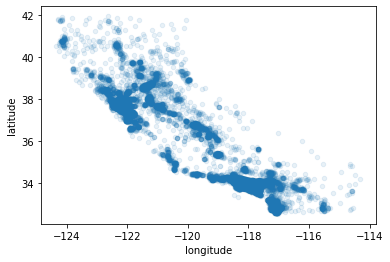

In [15]:
housing.plot(kind='scatter', x='longitude', y='latitude',alpha=0.1)

Já podemos começar a visualziar claramente quais são as áreas de maior densidade. Vamos incluir mais informação. Mapeamos para o tamanho dos círculos a população de cada distrito, e a cor o preço das casas.

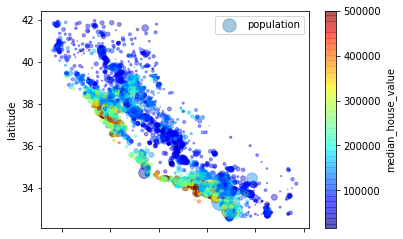

In [16]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, s=housing['population']/100, label='population', c='median_house_value' ,cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()

Este tipo de visualização, se feita adequadamente, pode ser muito útil para detectar previamente alguns padrões que nos ajudarão a determinar onde começar com nossos métodos, agora que temos um modo seguro de testá-lo mais tarde (o conjunto de teste).

Neste caso especificamente, notamos que os preços são maiores em regiões de maior população, e tendem a aumentar perto da costa, embora possamos ver alguns preços maiores mais ao interior na região norte.

#### Procurando correlações

**Coeficiente de correlação padrão:** também chamado de _r de Pearson_, quantifica a linearidade da relação entre duas variáveis.  É avaliado a partir 1, que identifica uma relação positiva forte, passa por 0, que identifica a ausência de relação linear, e vai até -1, indicando um relação negativa forte. Como se refere especificamente a relações _lineares_, relações claras mas completamente não-lineares ainda seriam avaliadas com 0.

Chamamos então o método _corr()_ para computar o coeficiente de correlação entre todos os pares de atributos do nosso conjunto de dados.

In [17]:
corr_matrix = housing.corr()

Vamos ver qual a relação entre cada atributo e o nosso alvo, o custo mediano de moradia.

In [18]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

Vemos claramente uma relação positiva forte entre o custo de moradia e a renda média, como se esperaria, e uma relação negativa mais considerável entre a latitude e o custo mediano.

Outro modo, talvez mais esclarecedor, de visualizar essas relações e suas intensidades é fazer o plot de pares de atributos que temos disponíveis. Para isso podemos usar a função _scatter_matrix_ da biblioteca Pandas, e escolhemos alguns dos atributos que parecem mais promissores de acordo com seus coeficientes de correlação.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff704f16da0>,
      dtype=object)

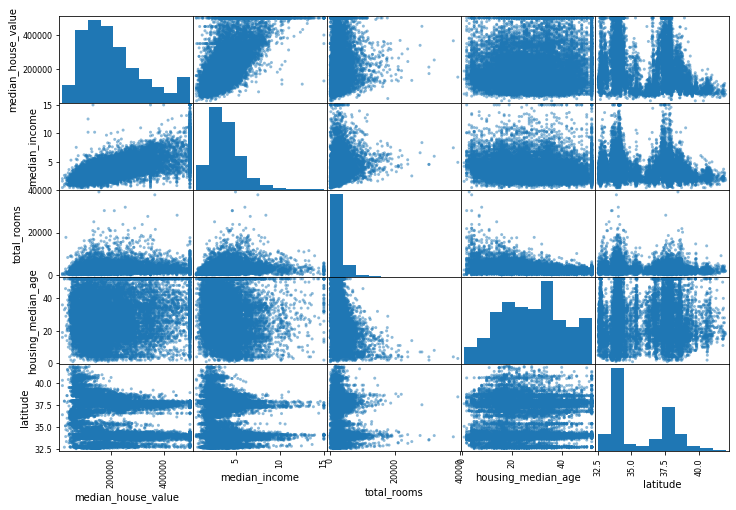

In [19]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age', 'latitude']
scatter_matrix(housing[attributes], figsize=(12,8))

A visualização não deixa dúvidas de que a renda mediana é o atributo mais promissor para determinação do custo mediano.

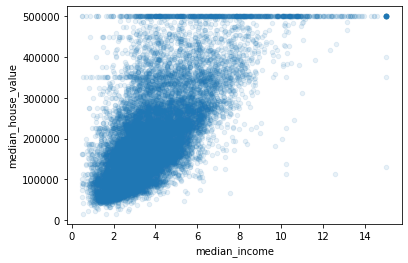

In [20]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

Vemos claramente que há uma relação positiva forte entre os dois atributos, e a dispersão não parece muito intensa. Notamos, entretanto, a presença de algumas linhas retas na distribuição. A mais intensa é claramente a linha de corte dos preços em 500.000 que já havíamos notado, mas podemos notar algumas outras, em torno de 450.00, 350.000, 280.000 e 220.000, por exemplo. Ao longo da preparação dos dados para o treinamento, este tipo de peculiaridade dos dados pode ser tratada para evitar que o algoritmo tende reproduzir esses comportamentos, se os julgarmos não naturais. 

#### Estudando combinações de atributos

Antes de concluir nossa análise, podemos querer ir um pouco mais a fundo. Embora a maioria dos atributos pareça não ter tido uma relação direta notável com o custo mediano, podemos ainda querer estudar combinações de atributos que façam sentido. Montamos três novas categorias que podem apresentar resultados interessantes abaixo.

In [21]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

Vamos estudar as correlações de novo, agora incluindo estes atributos.

In [22]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_rooms         -0.259984
Name: median_house_value, dtype: float64

E o número de quartos por cômodo parece ter uma relação a qual devemos dar atenção; é mais intensa que todas as outras relações negativas que tínhamos antes, então é útil a mantermos em mente.

Não precisamos, entretanto, fazer uma análise exaustiva de nossos dados antes mesmo de tentar aplicar algum método; o trabalho pesado será tarefa do algoritmo. A ideia deve ser apenas ganhar um entendimento melhor de nossas informações e uma noção geral daquilo que elas oferecem, encontrando alguns erros ou curiosidades que podemos querer tratar logo de início. Essas informações nos permitem fazer uma escolha informada em relação a como começar nosso trabalho. E, de todo modo, uma vez que tenhamos um sistema funcionando, podemos analizar os seus resultados e possivelmente descobrir algo que não era óbvio anteriormente, ganhando motivos para voltar ao passo de exploração do conjunto de dados.

## Preparação dos dados

Após essa exploração inicial, ainda temos que preparar nossos dados para nosso sistema. Em lugar de fazer isso manualmente, é útil escrever funções para esse propósito, que poderão ser aplicadas não só em futuros conjuntos de dados deste mesmo problema como também podem ser aproveitadas em outros projetos futuros.

Começamos retornando a um conjunto de treinamento limpo, que consistirá dos atributos que serão usados para predição do custo mediano de moradia. O custo manteremos numa lista de dados separada, que etiqueta cada uma das instâncias que usaremos para treinar nosso algoritmo.

In [23]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

#### Limpeza dos dados

Começamos pelo primeiro problema que notamos: algumas instâncias não possuem um valor para o atributo _total_bedrooms_. Algumas opções são:
* Eliminar os distritos correspondentes
* Elimar o atributo
* Dar um valor para o atributo nesses distritutos

Vamos escolher a terceira opção, e utilizar a função _SimpleImputer_ da biblioteca _Scikit-Learn_.

In [24]:
from sklearn.impute import SimpleImputer

# chamamos uma instância da função e definimos que queremos substituir 
# os valores vazios por uma mediana
imputer = SimpleImputer(strategy='median')
# criamos uma cópia que só contém os atributos numéricos para que a mediana possa ser computada
housing_num = housing.drop('ocean_proximity', axis=1)
# fitamos a instância do imputer aos nossos dados numéricos
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

A função simplesmente computou a mediana de todos os atributos numéricos. Podemos visualizar todos os nosos resultados.

In [25]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [26]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Nossa instância _imputer_ está agora treinada, e podemos chamar o método _transform_ para preencher os vazios com a mediana do atributo em questão., e então preenchemos a cópia do conjunto de treinamento que havíamos criado. Como estamos chamando as medianas de todos os atributos numéricos, este processo fará o mesmo para os valores vazios de todos os atributos caso isso ocorra com dados futuros.


In [27]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

#### Lidando com categorias e atributos de texto

Já tivemos que eliminar o atributo _ocean_proximity_ uma vez, por se tratar de texto. Como a maioria dos algoritmos de aprendizado de máquina preferem números, convém converter este atributo. Para isso chamamos o transformador _OrdinalEncoder_.

In [28]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat = housing[['ocean_proximity']]
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

O codificador atribuiu um inteiro para cada categoria. Podemos vizualizar a condificação com o atributo *categories_*. O número de cada categoria correspondente a sua posição no array, a partir de 0.

In [29]:
print(ordinal_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


Esta forma de caracterização apresenta o problema de que um modelo irá assumir que dois valores próximos representam características similares, o que não é verdade:: 0 e 4 são mais similares que 0 e 1, por exemplo. Uma alternativa é transformar a classificação deste atributo em um vetor one-hot. Para cada categoria, definimos um identificador binário; o identificador assume o valor 1 se a instância que está identificando pertence à categoria que ele representa, e 0 caso contrário. Assim, cada instância fica classificada no atributo _ocean_proximity_ por um vetor em que todas as entradas são _cold_ (0), exceto por uma, que é _hot_ (1), de onde vem o nome.

Para converter nossa classificação atual em uma codificação one-hot, podemos utilizar a função *OneHotEncoder*, que retorna uma matriz esparsa.

In [30]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [31]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Alternativamente, podemos aplicar ambas as transformações de uma vez com a classe *LabelBinarizer*. Ela retorna uma matriz densa por padrão, mas como a maioria das entradas consiste de zeros, convém especificar que o resultado seja dado em uma matriz esparsa.

In [32]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.int64'>'
	with 16512 stored elements in Compressed Sparse Row format>

#### Transformadores customizados

Ainda que a biblioteca Scikit-Learn ofereça uma variedade de processos úteis para o tratamento de dados, inevitavelmente será necessário ou simplesmente mais conveniente escrever nossos próprios transformadores para alguns problemas mais particulares de nosso trabalho. Ainda assim, dada a utilidade do que já é oferecido pela biblioteca, convém garantir que nossas funções trabalhem bem com aquelas da biblioteca.

Felizmente, é fácil garantir isso; o Scikit-Learn tipa funções por *duck typing* (ou tipagem de pato), isto é, se duas funções se comportam do mesmo modo, então elas são reconhecidas como a mesma função (*If it walks like a duck, and it quacks like a duck, then it must be a duck*). O que isso significa é que ao criar uma classe, basta implementar três métodos: *fit()* (retornando apenas *self*), *transform()* e *fit_transform()*. O último vem naturalmente se adicionarmos *TransformerMixin* como uma classe base. Se adicionarmos também *BaseEstimator* como uma classe base (evitando* *args* e _ ** kwargs_ no construtor), ganhamos dois métodos extras: *get_params()* e *set_params()*. Estes vêm a ser úteis para ajuste automático de hiperparâmetros (parâmetros do modelo que não são afetados pelo aprendizado).

A classe exemplo abaixo adiciona as três combinações de atributos que sugerimos antes.

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = [
    list(housing.columns).index(col)
    for col in ('total_rooms', 'total_bedrooms', 'population', 'households')]

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): 
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

Incluímos um hiperparâmetro que define a adição do atributo combinado. Isso permite facilmente ativar ou desativar esse atributo para que possamos analizar seu efeito no modelo e determinar se seu uso é vantajoso. Geralmente, é uma boa prática adicionar um parâmetro como esse a qualquer passo da preparação de data cuja utilidade seja incerta. Quando mais automatizados esses passos forem, mais combinações podemos testar automaticamente, aumentando as chances de encontrarmos uma combinação promissora e poupando tempo.

#### Escalamento de atributos

Uma das transformações mais importantes a serem aplicadas é o escalamento de atributos. De modo geral, algoritmos de aprendizado de máquina não se comportam bem quando os dados numéricos estão em escalas muito diferentes. Apenas os valores do atributo que queremos prever, em particular, não precisam de escalamento.

Há duas maneiras de regularizar a escala de todos os atributos: escalamento min-max e padroninzação.

**Escalamento min-max:** também chamado de **normalização**, simplesmente desloca e reescala valores para que se distribuam entre 0 e 1. Fazemos isso subtraindo o mínimo e dividindo pela diferença entre o máximo e o mínimo. O Scikit-Learn tem o transformador *MinMaxScaler* para esta função.

**Padronização:** primeiro subtrai o valor médio, deixando o resultado com média 0, e então divide pela variância, tal que o resultado tem variância unitária. Este método não limita valores a um intervalo específico, o que pode ser problemático para alguns algoritmos. Entretanto, padronização é muito menos afeta por pontos fora da curva. Este método pode ser aplicado pelo transformador *StandardScaler*, também parte do Scikit-Learn.

#### Pipelines de transformação

A esta altura, ficou claro que um conjunto de dados pode exigir várias transformações, que podem precisar serem executadas em uma ordem particular. Scikit-Learn fornece a classe *Pipeline* precisamente para este propósito. Abaixo, temos um exemplo de instância da classe que aplica as transformações já discutidas sobre os atributos numéricos.

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

Como as transformações sobre atributos de texto neste caso podem ser feitas com uma única função, escrevemos uma pipeline completa que inclui essa transformação e a pipeline numérica. Utilizamos o transformador *ColumnTransformer*, que permite aplicarmos cada transformação a partes diferetes do nosso conjunto de dados.

In [35]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

housing_prepared = full_pipeline.fit_transform(housing)

In [36]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [37]:
housing_prepared.shape

(16512, 16)

## Selecionar e treinar um modelo

Passamos agoras pelos passos principais da preparação do problema: entendemos qual é o problema em si, analizados nossos dados, separados nosso conjunto e escrevemos as pipelines para limpar e preparar nossos dados. Podemos agora partir para a seleção e implementação de algoritmos de aprendizado de máquina.

#### Treinando e avaliando no conjunto de treino

Vamos experimentar primeiro treinar um modelo de regressão linear.

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Começamos tomando apenas algumas instâncias.

In [39]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:\t', lin_reg.predict(some_data_prepared))

Predictions:	 [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [40]:
print('Labels:\t\t', list(some_labels))

Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


Não são resultados terríveis: a primeira lista mostra as predições feitas pelo modelo para o atributo *median_house_value*, e a segunda os valores reais para essas instâncias. Ainda assim, claramente não são adequados para uso prático. Vamos analizar o desvio RMS do conjunto todo.

In [41]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Considerando que este valor é em torno de 50% dos valores mais comuns de preços medianos, claramente a regressão linear, ao menos como está, não se mostra adequada. Este é um exemplo do modelo não se adequando suficientemente bem aos dados (*underfitting*). Diante dessa situação, alguns procedimentos que podem ser adequados são:
* Usar um modelo mais poderoso (flexível)
* Dar ao mesmo modelo atributos melhores
* Diminuir as restrições impostas sobre o modelo

A última opção já é impossível, pois não colocamos enhuma restrição sobre a regressão linear. Poderíamos tentar a segunda, mas comecemos pela primeira.

Tentemos então aplicar uma árvore de decisão, e analizemos seu desvio RMS.

In [42]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [43]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Um resultado perfeito, o que significa que algo deve estar errado. Uma possibilidade para este caso é o oposto do que ocorreu com a regressão linear: *overfitting*. O modelo foi poderoso o suficiente para se adequar perfeitamente ao conjunto de treino, mas em consequência pode resultar em desvio grandes para outras instâncias.

#### Uma avaliação melhor utilizando validação cruzada

Um modo de avaliar com mais segurança o modelo da árvore de decisão seria dividir o conjunto de treinamento em um conjunto de treinamento menor e um conjunto de validação, treinar o modelo contra o primeiro e testá-lo contra o segundo.

Uma alternativa é utilizar a função *cross-validation* do Scikit-Learn. O código abaixo faz *K-fold cross-validation*: divide o conjunto de treinamento em 10 subconjuntos chamados dobras e avalia o modelo dez vezes, escolhendo uma dobra diferente para avaliação a cada vez e treinando nas outras nove.

In [44]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error', cv=10)
rmse_scores = np.sqrt(-scores)

In [45]:
def display_scores(scores):
    print('Scores:', scores)
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())

In [46]:
display_scores(rmse_scores)

Scores: [69016.63288167 66227.25276654 70888.93196334 70102.50057218
 70312.12044396 74005.05377045 71800.61204254 71126.76115866
 76713.52039603 69197.53652125]
Mean: 70939.09225166208
Standard deviation: 2711.9618261174382


O array resultante contém as pontuações das dez avaliações. Quando passamos à função *'neg_mean_squared_error* como o parâmetro *scoring* definimos que a pontuação deve ser calculada como o erro RMS. A validação cruzada do Scikit-Learn espera uma função de utilidade, e não uma uma função de custo, portanto a função de pontuação é na verdade o oposto de MSE, e por isso incluímos no código *-scores*.

Vamos fazer o mesmo para a regressão linear.

In [47]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error',cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798348


Embora a diferença não seja tão grande, o overfitting da árvore de decisão está tornando seu resultado pior que o da regressão linear! 

Ambos os modelos que testamos apresenteram resultados que não parecem muito adequados. Tentemos um terceiro: *RandomForestRegressor*. Este modelo treina várias árvores de decisão em vários subconjuntos aleatórios, e então calcula a média de suas predições. O método de construir um modelo com base em vários modelos é chamado de *ensemble learning*.  

In [55]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10,random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [58]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

21933.31414779769

In [61]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels, scoring='neg_mean_squared_error',cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [51646.44545909 48940.60114882 53050.86323649 54408.98730149
 50922.14870785 56482.50703987 51864.52025526 49760.85037653
 55434.21627933 53326.10093303]
Mean: 52583.72407377466
Standard deviation: 2298.353351147122


Obtivemos com este método um erro consideravelmente menor que nos outros casos. Mas é importante notar que o desvio obtido com a divisão do conjunto em conjuntos de validação ainda é muito maior que aquele que obtemos testando sobre o conjunto de treino. Isso é um sinal de que ainda temos um problema de overfitting com o conjunto de treino. Soluções possíveis para overfitting incluem um modelo mais simples, restringir o modelo presente ou incluir mais dados.

Ainda assim, antes de investir demais em qualquer modelo específico, é bom investigar superficialmente vários modelos diferentes, com o objetivo de listar alguns modelos promissores (sugere-se entre 2 e 5).

## Ajuste fino do modelo

Uma vez que tenhamos nossa lista de modelos, passamos a um ajuste fino deles para que possamos filtrar o que é mais adequado.

#### Busca de malha

Uma maneira de fazer este ajuste seria impor alguns parâmetros que pareçam sensíveis sobre o modelo, e então manualmente ajustá-los até encontrar o valor ideal (ou suficientemente bom), o que consumiria um bom tempo. Em lugar disso, fazemos uso da classe *GridSearchCV* do Scikit-Learn. Chamando uma instância dessa classe, simplesmente passamos os hiperparâmetros que desejamos ajustar e quais valores testar; a partir daí, o programa avalia todas as combinações possíveis por validação cruzada.

Fazemos isso abaixo para o *RandomForestRegressor*

In [64]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3,10,30], 'max_features': [2,4,6,8]},
    {'bootstrap': [False], 'n_estimators': [3,10], 'max_features': [2,3,4]},
]

# Esta lista informará ao método que deve primeiro avaliar todas as combinações possíveis dos dois hiperparâmetros no primeiro dicionário
# e em seguida, todas as combinações possíveis no segundo dicionário, dessa vez com o parâmetro bootstrap como False

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6, 8],


Com os testes completos, podemos pedir os resultados:

In [65]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

Ou simplesmente receber o melhor estimador já preparado.

In [66]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=8, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=30,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

E se quiseremos analisar os outros resultados, temos as pontuações, como antes.

In [71]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63748.341646851826 {'max_features': 2, 'n_estimators': 3}
55692.066613052884 {'max_features': 2, 'n_estimators': 10}
52877.11695607506 {'max_features': 2, 'n_estimators': 30}
61231.37396258081 {'max_features': 4, 'n_estimators': 3}
52852.566487682685 {'max_features': 4, 'n_estimators': 10}
50783.93481859857 {'max_features': 4, 'n_estimators': 30}
59597.29549633753 {'max_features': 6, 'n_estimators': 3}
52006.26328874846 {'max_features': 6, 'n_estimators': 10}
50078.90948149048 {'max_features': 6, 'n_estimators': 30}
59847.828849930585 {'max_features': 8, 'n_estimators': 3}
51758.103390094264 {'max_features': 8, 'n_estimators': 10}
49934.49870917605 {'max_features': 8, 'n_estimators': 30}
61965.733312468496 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54955.489023316135 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61304.11599584767 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53194.49942160567 {'bootstrap': False, 'max_features': 3, 'n_estimato

A melhor combinação, *'max_features': 8, 'n_estimators': 30*, nos dá uma pontuação de 49934, um pouco menor que 52583, que haviamos recebido antes com os valores padrão de hiperparâmetros, então podemos tomar essa nova configuração como o ajuste de nosso modelo. 

#### Busca aleatória

Para poucas combinações, a busca de malha é suficiente para o ajuste dos hiperparâmetros. Quando o espaço de busca desses valores, todavia, é grande, é frequente preferível utilizar *RandomizedSearchCV*. Essa classe é utilizada de modo similar a *GridSearchCV*, mas avalia um número de combinações aleatórias em que cada hiperparâmetro recebe um valor aleatório a cada iteração. Esse processo tem a vantagem de sempre selecionar valores diferentes por hiperparâmetro, em vez de alguns valores definidos. O número de iterações que definimos limita o custo do método, e o número de valores testados.

#### Métodos de ensemble

Outra maneira é combinar diferentes métodos. Já experimentamos com essa ideia ao trocar as árvores de decisão por florestas aleatórias: utilizamos vários métodos, ou o mesmo método várias vezes, para obter um resultado melhor onde podemos, por exemplo, tomar a média de execuções diferentes ou corrigir as fraquezas de um método com os fortes de outro. 

#### Analizando os melhores modelos e seus erros

Neste estágio, uma maneira de ganhar uma maior compreensão do problema é inspecionar os modelos que agora sabemos seem os melhores. *RandomForestRegressor*, por exemplo, pode nos indicar a importância relativa de cada atributo em previsões precisas.

In [74]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ['rooms_per_hhold', 'pop_per_hold', 'bedrooms_per_room']
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.3432970722266834, 'median_income'),
 (0.16560650077612318, 'INLAND'),
 (0.11053855490102629, 'pop_per_hold'),
 (0.07484810152347546, 'longitude'),
 (0.06753245263291568, 'bedrooms_per_room'),
 (0.06431444620357706, 'latitude'),
 (0.05828024821076018, 'rooms_per_hhold'),
 (0.04091378594650709, 'housing_median_age'),
 (0.015204790211300343, 'total_rooms'),
 (0.015118441724239798, 'population'),
 (0.014674755669135139, 'total_bedrooms'),
 (0.013832997012369064, 'households'),
 (0.008501903131000195, '<1H OCEAN'),
 (0.004423138023632831, 'NEAR OCEAN'),
 (0.0028652282259555746, 'NEAR BAY'),
 (4.758358129870076e-05, 'ISLAND')]

A partir daqui, podemos confirmar algumas de nossas ideias iniciais (a importância do atributo *median_income*, por exemplo), ou determinar e eliminar alguns dos atributos menos úteis, por exemplo. 

Podemos também olhar para erros específicos cometidos pelo sistema, tentar entender sua causa e então como resolver o problema.

#### Avaliar o sistema no conjunto de teste

Após passar algum tempo ajustando o sistema, chegamos a algo que funciona suficientemente bem, e estamos prontos para avaliar o modelo no conjunto de teste.

Primero temos que preparar os dados de teste para nossos métodos, assim como fizemos como os dados de treino. Simplesmente aplicamos os mesmos processos que já foram cosntruídos.

In [75]:
final_model = grid_search.best_estimator_

x_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

x_test_prepared = full_pipeline.transform(x_test)

final_predictions = final_model.predict(x_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [76]:
final_rmse

47897.01072444243

A comparação com os dados do conjunto de teste resulta em um erro menor que o que havíamos conseguido após o ajuste dos hiperparâmetros. Isso é um bom sinal de que evitamos um overfitting do nosso modelo ao conjunto de treino. Se houvéssemos obtido um erro maior, não devemos tentar alterar nosso modelo para obter um resultado melhor no conjunto de teste: desse modo, estaríamos apenas adaptando nosso modelo para dar bons resultados no conjunto de teste *especificamente*, o que não levará a melhores resultados em aplicações em larga escala, uma vez que o código passe a ser usado com fins práticos.

## Lançamento, monitoramento e manutenção do sistema

Uma vez que o código passe a ser utilizado para o propósito para qual foi criado, o trabalho não terá terminado. Será neccessário ainda escrever um código de monitoração da eficiência, checando-a regularmente e emitindo avisos quando ela cair abaixo de um certo nível. Isto permite descobrir tanto erros súbitos quanto detectar a degradação da performance com o tempo, que é um problema comum desses sistemas com a evolução dos dados, e é evitado com retrainmento regular.

A avaliação da performance exigirá que alguém tome uma amostra de predições e as estude. Monitoração também deve ser feita sobre os dados de entrada, uma vez que o desempenho pode se deteriorar também como consequência de sinais de baixa qualidade, mas esses deterioração pode demorar um tempo para se acumular suficientemente na saída do modelo para ativar um alerta. O monitoramento dos dados de entrada em si evita que este problema demore mais do que precisa para ser detectado. 

Quanto ao retreinamento com dados novos, geralmente é uma boa prática realizá-lo regularmente. Quanto mais .automatizado o processo for, mais fácil é o processo, dando importância à construção adequada de pipelines, métodos de ajuste fino e outros pontos discutidos aqui